In [62]:
from pathlib import Path 
import os
import torch
import pandas as pd
from tqdm import tqdm
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
from torch.nn.modules.loss import CrossEntropyLoss
from kapoorlabs_lightning.optimizers import Adam
from kapoorlabs_lightning.pytorch_models import HybridAttentionDenseNet
from kapoorlabs_lightning.lightning_trainer import LightningModel
from napatrackmater.Trackvector import (
    inception_model_prediction,
    save_cell_type_predictions,
    SHAPE_DYNAMIC_FEATURES
)
from matplotlib import cm
import matplotlib.pyplot as plt

In [46]:
dataset_name = 'Sixth'
home_folder = '/home/debian/jz/'
model_dir = f'{home_folder}Mari_Models/TrackModels/'
mitosis_model_name = 'morphodynamic_feature_mitosis_25_growth_rate_16'
gbr_model_name = 'morpho_feature_attention_shallowest_litest_nuclei_'
channel = 'nuclei_'
tracking_directory = f'{home_folder}Mari_Data_Oneat/Mari_{dataset_name}_Dataset_Analysis/nuclei_membrane_tracking/'
data_frames_dir = os.path.join(tracking_directory, f'dataframes/')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tracklet_length = 25
normalized_dataframe = os.path.join(data_frames_dir , f'goblet_basal_dataframe_normalized_{channel}.csv')
print(f'reading data from {normalized_dataframe}')
tracks_dataframe = pd.read_csv(normalized_dataframe)

mitosis_morpho_model_json = f'{model_dir}{mitosis_model_name}/morphodynamic_mitosis_densenet.json'
gbr_morpho_model_json = f'{model_dir}{gbr_model_name}/morpho_attention.json'
class_map_mitosis = {
    0: "Non-Mitotic",
    1: "Mitotic",
}
class_map_gbr = {
        0: "Basal",
        1: "Radial",
        2: "Goblet"
    }
loss_func =  CrossEntropyLoss()

mitosis_morpho_lightning_model, mitosis_morpho_torch_model = LightningModel.extract_mitosis_model(
    HybridAttentionDenseNet,
    mitosis_morpho_model_json,
    loss_func,
    Adam,
    map_location=torch.device(device),
    local_model_path=os.path.join(model_dir, mitosis_model_name)
)

mitosis_morpho_torch_model.eval()

gbr_morpho_lightning_model, gbr_morpho_torch_model = LightningModel.extract_mitosis_model(
    HybridAttentionDenseNet,
    gbr_morpho_model_json,
    loss_func,
    Adam,
    map_location=torch.device(device),
    local_model_path=os.path.join(model_dir, gbr_model_name)
)

gbr_morpho_torch_model.eval()


reading data from /home/debian/jz/Mari_Data_Oneat/Mari_Sixth_Dataset_Analysis/nuclei_membrane_tracking/dataframes/goblet_basal_dataframe_normalized_nuclei_.csv


/home/debian/python_workspace/KapoorLabs-Lightning/src/kapoorlabs_lightning/lightning_trainer.py:1135: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


HybridAttentionDenseNet(
  (temporal_encoding): TemporalEncoding()
  (features): Sequential(
    (conv_init): Conv1d(18, 32, kernel_size=(7,), stride=(2,), padding=(3,))
    (bn_init): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_init): ReLU(inplace=True)
    (maxpool_init): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock0): DenseBlock(
      (denselayer0): DenseLayer(
        (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv2): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
        (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv1): Conv1d(16, 4, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (denselayer1): DenseLayer(
        (bn2): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

SelectionSlider(continuous_update=False, description='TrackMate ID:', options=(115, 189, 111, 145, 60, 30, 114…

Processing TrackMate Track ID: 115
Trackmate ID: 115,  GT mitosis track '1.0' GT gbr track 'Basal', track duration 92089
Prediction mitosis track 'Mitotic' Prediction gbr track 'Basal'


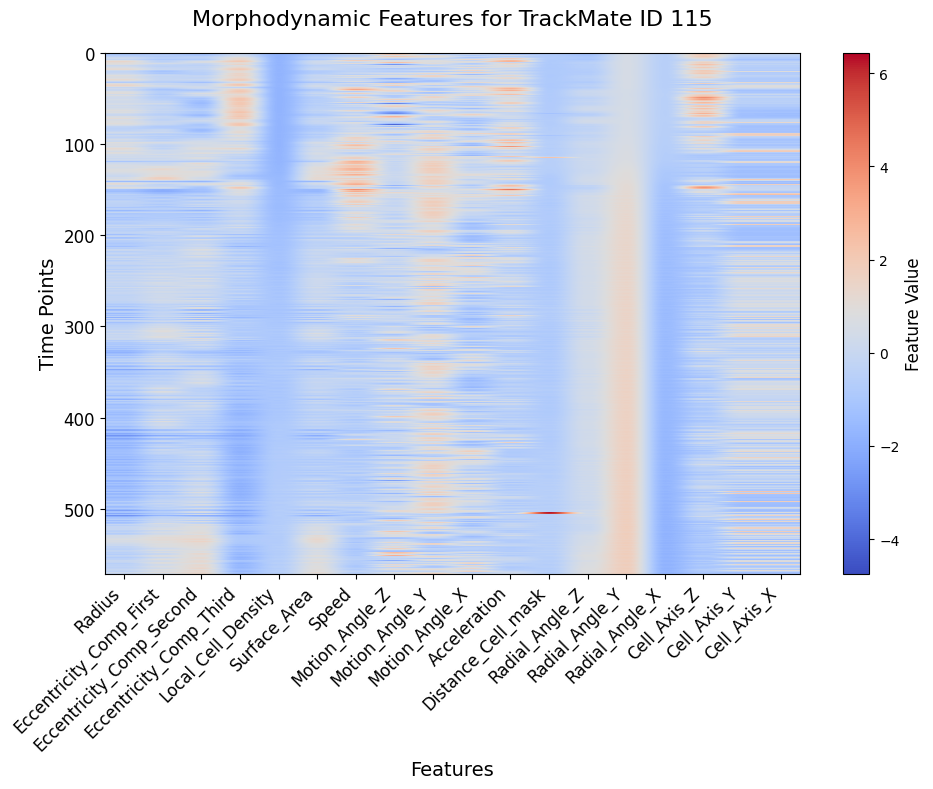

In [70]:
all_trackmate_ids = [trackid  for trackid in tracks_dataframe['TrackMate Track ID'].unique()]

colormap = cm.get_cmap('tab20', len(SHAPE_DYNAMIC_FEATURES))

trackmate_slider = widgets.SelectionSlider(
    options=all_trackmate_ids,  
    value=all_trackmate_ids[0],  
    description="TrackMate ID:",
    continuous_update=False
)

trackmate_textbox = widgets.BoundedIntText(
    value=all_trackmate_ids[0], 
    min=min(all_trackmate_ids),
    max=max(all_trackmate_ids),
    description="TrackMate ID:",
)



def process_trackmate_id(trackmate_id):
    
    
    clear_output(wait=True)
    display(trackmate_slider)
    print(f"Processing TrackMate Track ID: {trackmate_id}")
    
    gbr_prediction = inception_model_prediction(tracks_dataframe, trackmate_id, tracklet_length, class_map_gbr, morphodynamic_model=gbr_morpho_torch_model, device=device)
    mitosis_prediction = inception_model_prediction(tracks_dataframe, trackmate_id, tracklet_length, class_map_mitosis, morphodynamic_model=mitosis_morpho_torch_model, device=device)
    if len(tracks_dataframe[tracks_dataframe['TrackMate Track ID'] == trackmate_id]) > 0:
        track_duration = tracks_dataframe[tracks_dataframe['TrackMate Track ID'] == trackmate_id]['Track Duration'].iloc[0]
        track_mitosis = tracks_dataframe[tracks_dataframe['TrackMate Track ID'] == trackmate_id]['Dividing'].iloc[0]
        track_celltype = tracks_dataframe[tracks_dataframe['TrackMate Track ID'] == trackmate_id]['Cell_Type'].iloc[0]
        print(f"Trackmate ID: {trackmate_id},  GT mitosis track '{track_mitosis}' GT gbr track '{track_celltype}', track duration {track_duration}")
        print(f"Prediction mitosis track '{mitosis_prediction}' Prediction gbr track '{gbr_prediction}'")
        morphodynamic_features = tracks_dataframe[tracks_dataframe['TrackMate Track ID'] == trackmate_id][SHAPE_DYNAMIC_FEATURES].to_numpy()
        fig_width = max(10, len(SHAPE_DYNAMIC_FEATURES) * 0.5)  
        plt.figure(figsize=(fig_width, 8))
        plt.imshow(morphodynamic_features,aspect='auto', cmap='coolwarm')
        
        plt.title(f'Morphodynamic Features for TrackMate ID {trackmate_id}', fontsize=16, pad=20)
        plt.xlabel('Features', fontsize=14)
        plt.ylabel('Time Points', fontsize=14)

        plt.xticks(
                ticks=np.arange(len(SHAPE_DYNAMIC_FEATURES)),
                labels=SHAPE_DYNAMIC_FEATURES,
                fontsize=12,
                rotation=45,  
                ha='right'  
            )
        plt.yticks(fontsize=12)

        cbar = plt.colorbar()
        cbar.set_label('Feature Value', fontsize=12)
        cbar.ax.tick_params(labelsize=10)

        # Improving layout
        plt.tight_layout()
        plt.show()
        
    else:
        print(f'Dataframe is empty skipping {trackmate_id}')    

def on_slider_change(change):
    process_trackmate_id(change['new'])



trackmate_slider.observe(on_slider_change, names='value')

process_trackmate_id(trackmate_slider.value)